In [2]:
import pandas as pd
import scipy
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from collections import defaultdict
from itertools import combinations
from scipy import stats 
import matplotlib.font_manager 
from pyod.models.knn import KNN 
from pyod.utils.data import generate_data, get_outliers_inliers 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [3]:
#Load the dataset
df= pd.read_csv('Ratings_Electronicsnew.csv')
print(df.head())
print(df.columns)

           USERID  ProductID  Ratings       Times
0   AKM1MP6P0OYPR  132793040        5  1365811200
1  A2CX7LUOHB2NDG  321732944        5  1341100800
2  A2NWSAGRHCP8N5  439886341        1  1367193600
3  A2WNBOD3WNDNKT  439886341        3  1374451200
4  A1GI0U4ZRJA8WN  439886341        1  1334707200
Index(['USERID', 'ProductID', 'Ratings', 'Times'], dtype='object')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048099 entries, 0 to 1048098
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   USERID     1048099 non-null  object
 1   ProductID  1048099 non-null  object
 2   Ratings    1048099 non-null  int64 
 3   Times      1048099 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 32.0+ MB


In [5]:
df.isnull().sum()


USERID       0
ProductID    0
Ratings      0
Times        0
dtype: int64

In [6]:
df.describe()

,Ratings,Times
count,1.048099e+06,1.048099e+06
mean,3.973294e+00,1.248805e+09
std,1.399413e+00,1.091690e+08
min,1.000000e+00,9.127296e+08
25%,3.000000e+00,1.169078e+09
50%,5.000000e+00,1.249949e+09
75%,5.000000e+00,1.355789e+09
max,5.000000e+00,1.406074e+09


In [7]:
df.shape

(1048099, 4)

In [8]:
df.describe()['Ratings'].T

count    1.048099e+06
mean     3.973294e+00
std      1.399413e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Ratings, dtype: float64

In [9]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(df.Ratings.min()))
print('Maximum rating is: %d' %(df.Ratings.max()))

Minimum rating is: 1
Maximum rating is: 5


In [10]:
#Check for missing values
print('Number of missing values across columns: \n',df.isnull().sum())

Number of missing values across columns: 
 USERID       0
ProductID    0
Ratings      0
Times        0
dtype: int64


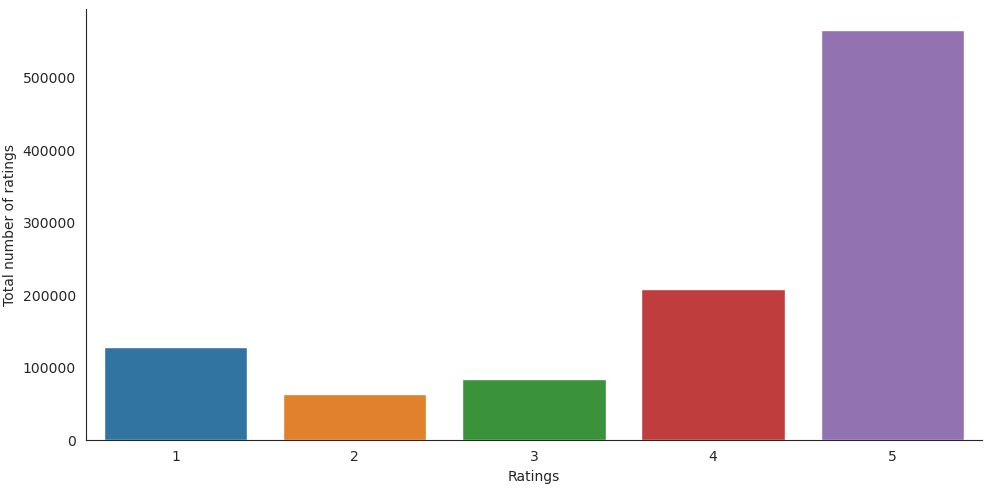

In [11]:
import seaborn as sns

# Check the distribution of the ratings
with sns.axes_style('white'):
    g = sns.catplot(x="Ratings", data=df, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")


In [12]:
print(df.columns)

Index(['USERID', 'ProductID', 'Ratings', 'Times'], dtype='object')


In [13]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
uid= "USERID "
print("Total No of Users   :", len(np.unique(df.USERID)))
print("Total No of products  :", len(np.unique(df.ProductID)))

Total data 
--------------------------------------------------

Total no of ratings : 1048099
Total No of Users   : 786024
Total No of products  : 61890


In [14]:
#Dropping the Times column

df.drop(['Times'], axis=1,inplace=True)

In [15]:
#Analysis of rating given by the user

no_of_rated_products_per_user = df.groupby(by='USERID')['Ratings'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

USERID
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Ratings, dtype: int64

In [16]:
no_of_rated_products_per_user.describe()

count    786024.000000
mean          1.333419
std           1.385460
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: Ratings, dtype: float64

In [17]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

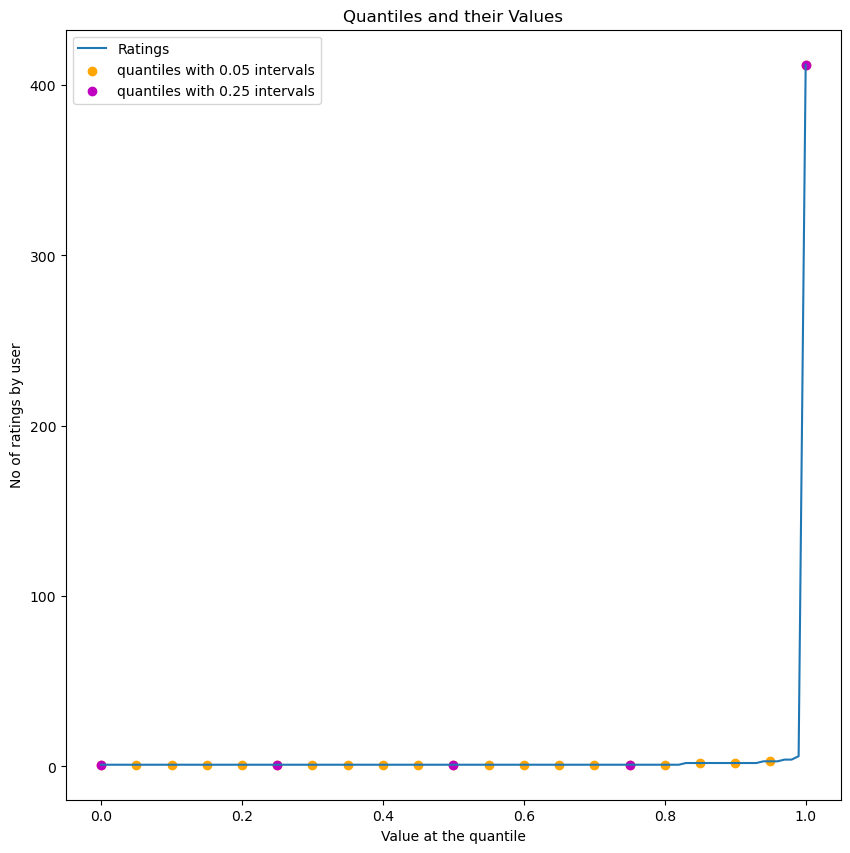

In [18]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [19]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 38



In [20]:
#Getting the new dataframe which contains users who has given 50 or more ratings

new_df=df.groupby("ProductID").filter(lambda x:x['Ratings'].count() >=50)

In [21]:
df.columns


Index(['USERID', 'ProductID', 'Ratings'], dtype='object')

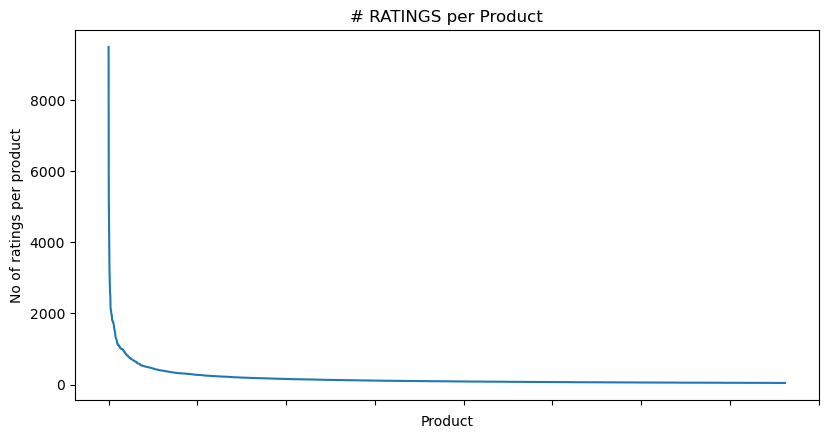

In [22]:
no_of_ratings_per_product = new_df.groupby(by='ProductID')['Ratings'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])
plt.show()

In [23]:
#Average rating of the product

new_df.groupby('ProductID')['Ratings'].mean().head()

ProductID
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
1400532655    3.727273
Name: Ratings, dtype: float64

In [24]:
new_df.groupby('ProductID')['Ratings'].mean().sort_values(ascending=False).head()

ProductID
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: Ratings, dtype: float64

In [25]:
#Total number of rating for product
new_df.groupby('ProductID')['Ratings'].count().sort_values(ascending=False).head()

ProductID
B0002L5R78    9487
B0001FTVEK    5345
B000I68BD4    4903
B000BQ7GW8    4275
B00007E7JU    3523
Name: Ratings, dtype: int64

In [26]:
ratings_mean_count = pd.DataFrame(new_df.groupby('ProductID')['Ratings'].mean())

In [27]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('ProductID')['Ratings'].count())

In [28]:
ratings_mean_count.head()

,Ratings,rating_counts
ProductID,,
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171
1400532655,3.727273,484


In [29]:
ratings_mean_count['rating_counts'].max()

9487

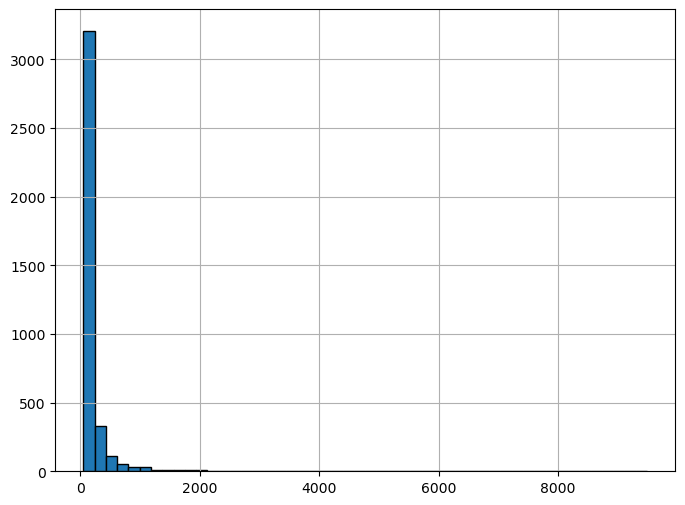

In [30]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)
plt.show()

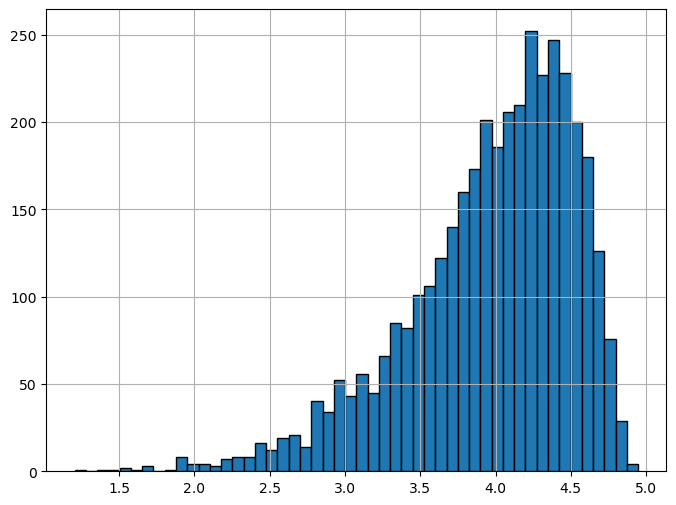

In [31]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Ratings'].hist(bins=50)
plt.show()

<Figure size 800x600 with 0 Axes>

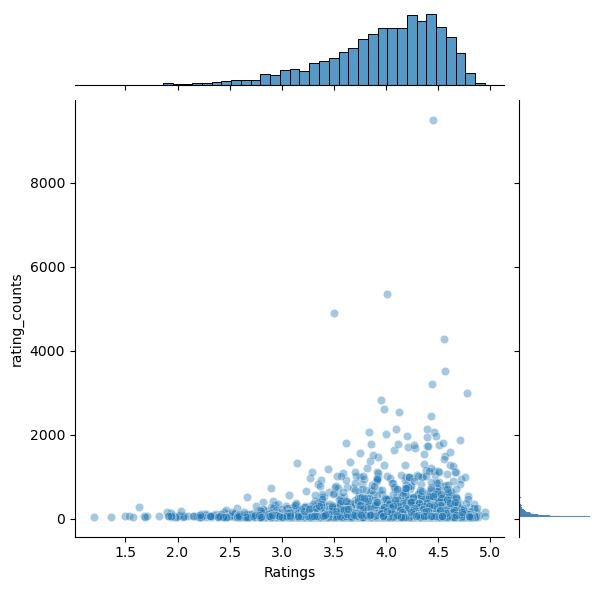

In [32]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Ratings', y='rating_counts', data=ratings_mean_count, alpha=0.4)
plt.show()

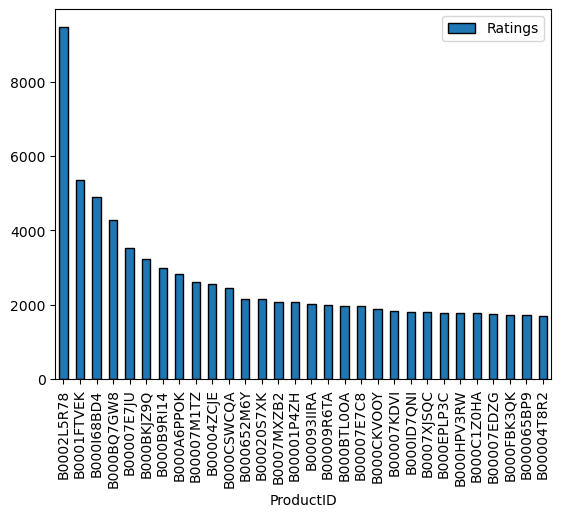

In [33]:
popular_products = pd.DataFrame(new_df.groupby('ProductID')['Ratings'].count())
most_popular = popular_products.sort_values('Ratings', ascending=False)
most_popular.head(30).plot(kind = "bar")
plt.show()

In [34]:
df

,USERID,ProductID,Ratings
0,AKM1MP6P0OYPR,132793040,5
1,A2CX7LUOHB2NDG,321732944,5
2,A2NWSAGRHCP8N5,439886341,1
3,A2WNBOD3WNDNKT,439886341,3
4,A1GI0U4ZRJA8WN,439886341,1
...,...,...,...
1048094,A3JR1W3HL4U6AY,B000IF4788,5
1048095,A13ZS9HDALWNK9,B000IF4788,5
1048096,A26AUEU9VV0D12,B000IF4788,5
1048097,A33GEECSY4J9IZ,B000IF4788,4


In [35]:
grouped = df.groupby('ProductID')['Ratings'].apply(list)

In [36]:
te = TransactionEncoder()
te_ary = te.fit(grouped).transform(grouped)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [37]:
fpgrowth(df, min_support=0.1,use_colnames=True)

,support,itemsets
0,0.780692,(5)
1,0.534174,(4)
2,0.421845,(1)
3,0.300016,(2)
4,0.359266,(3)
5,0.426482,"(4, 5)"
6,0.284262,"(1, 4)"
7,0.333592,"(1, 5)"
8,0.257748,"(1, 4, 5)"
9,0.254241,"(2, 5)"


In [38]:
dataset = [
    # User ratings
    ["USERID", "132793040", "5", "1365811200"],
    ["USERID", "321732944", "5", "1341100800"],
    ["USERID", "439886341", "1", "1367193600"],
    ["USERID", "439886341", "3", "1374451200"],
    ["USERID", "439886341", "1", "1334707200"],
    ["USERID", "511189877", "5", "1397433600"],
    ["USERID", "511189877", "2", "1397433600"],
    ["USERID", "511189877", "5", "1395878400"],
    ["USERID", "511189877", "5", "1395532800"],
    ["USERID", "511189877", "5", "1395446400"],
    ["USERID", "511189877", "5", "1401321600"],
    ["USERID", "528881469", "5", "1405641600"],
    ["USERID", "528881469", "1", "1352073600"],
    ["USERID", "528881469", "5", "1370131200"],
    ["USERID", "528881469", "1", "1290643200"],
    ["USERID", "528881469", "4", "1280016000"],
    ["USERID", "528881469", "3", "1283990400"],
    ["USERID", "528881469", "2", "1290556800"],
    ["USERID", "528881469", "2", "1277078400"],
    ["USERID", "528881469", "4", "1294790400"],
    ["USERID", "528881469", "5", "1293235200"],
    ["USERID", "528881469", "4", "1289001600"],
    ["A2AEHUKOV014BP", "528881469", "5", "1284249600"],
    ["AMLFNXUIEMN4T", "528881469", "1", "1307836800"],
    ["A2O8FIJR9EBU56", "528881469", "4", "1278547200"],
    # More user ratings...
    # Average ratings...
]

# Function to generate frequent itemsets using Eclat algorithm
def eclat(dataset, min_support):
    # Count the occurrences of each item
    item_counts = defaultdict(int)
    for transaction in dataset:
        items = set(transaction[1:])  # Exclude the USERID
        for item in items:
            item_counts[item] += 1
    
    # Generate frequent itemsets
    frequent_itemsets = []
    for item, count in item_counts.items():
        if count >= min_support:
            frequent_itemsets.append(([item], count))

    # Extend frequent itemsets
    for i in range(2, len(dataset)):
        extensions = []
        for itemset, _ in frequent_itemsets:
            for item in item_counts:
                if item not in itemset:
                    extended_itemset = sorted(itemset + [item])
                    if extended_itemset not in extensions:
                        extensions.append(extended_itemset)
        new_frequent_itemsets = []
        for extension in extensions:
            count = 0
            for transaction in dataset:
                if set(extension).issubset(set(transaction[1:])):
                    count += 1
            if count >= min_support:
                new_frequent_itemsets.append((extension, count))
        frequent_itemsets.extend(new_frequent_itemsets)

    return frequent_itemsets

# Set minimum support threshold
min_support = 2

# Find frequent itemsets using Eclat algorithm
frequent_itemsets = eclat(dataset, min_support)

# Print frequent itemsets
for itemset, support in frequent_itemsets:
    print("Itemset:", itemset, "Support:", support)


Itemset: ['5'] Support: 11
Itemset: ['1'] Support: 5
Itemset: ['439886341'] Support: 3
Itemset: ['3'] Support: 2
Itemset: ['511189877'] Support: 6
Itemset: ['1397433600'] Support: 2
Itemset: ['2'] Support: 3
Itemset: ['528881469'] Support: 14
Itemset: ['4'] Support: 4
Itemset: ['5', '511189877'] Support: 5
Itemset: ['5', '528881469'] Support: 4
Itemset: ['1', '439886341'] Support: 2
Itemset: ['1', '528881469'] Support: 3
Itemset: ['1397433600', '511189877'] Support: 2
Itemset: ['2', '528881469'] Support: 2
Itemset: ['4', '528881469'] Support: 4
Itemset: ['5', '511189877'] Support: 5
Itemset: ['5', '528881469'] Support: 4
Itemset: ['1', '439886341'] Support: 2
Itemset: ['1', '528881469'] Support: 3
Itemset: ['1397433600', '511189877'] Support: 2
Itemset: ['2', '528881469'] Support: 2
Itemset: ['4', '528881469'] Support: 4
Itemset: ['5', '511189877'] Support: 5
Itemset: ['5', '528881469'] Support: 4
Itemset: ['1', '439886341'] Support: 2
Itemset: ['1', '528881469'] Support: 3
Itemset: ['

In [39]:
# Step 1: Data Preprocessing
# Assuming the dataset is provided as a list of transactions
transactions = [
    ["132793040", "321732944", "439886341", "511189877", "528881469"],
    ["439886341", "511189877", "528881469"],
    ["132793040", "439886341", "511189877", "528881469"],
    ["132793040", "321732944", "511189877", "528881469"],
    ["132793040", "511189877", "528881469"],
    ["132793040", "439886341", "511189877", "528881469"],
    ["132793040", "439886341", "511189877", "528881469"],
    ["132793040", "439886341", "511189877", "528881469"],
    ["132793040", "439886341", "511189877", "528881469"],
    ["132793040", "511189877", "528881469"],
    ["132793040", "511189877", "528881469"],
    ["132793040", "511189877", "528881469"],
    ["132793040", "511189877", "528881469"],
    ["132793040", "511189877", "528881469"],
    ["132793040", "511189877", "528881469"],
    ["132793040", "511189877", "528881469"],
    ["132793040", "511189877", "528881469"],
    ["132793040", "511189877", "528881469"],
    ["132793040", "511189877", "528881469"]
]

# Step 2: Apriori Algorithm
def apriori(transactions, min_support):
    item_counts = defaultdict(int)
    for transaction in transactions:
        for item in transaction:
            item_counts[item] += 1

    num_transactions = len(transactions)
    frequent_itemsets = []
    for item, count in item_counts.items():
        support = count / num_transactions
        if support >= min_support:
            frequent_itemsets.append((item,))

    k = 2
    while True:
        next_itemsets = []
        for itemset in combinations(set.union(*[set(itemset) for itemset in frequent_itemsets]), k):
            itemset_count = 0
            for transaction in transactions:
                if set(itemset).issubset(set(transaction)):
                    itemset_count += 1
            support = itemset_count / num_transactions
            if support >= min_support:
                next_itemsets.append(itemset)
        if not next_itemsets:
            break
        frequent_itemsets.extend(next_itemsets)
        k += 1

    return frequent_itemsets

# Step 3: Define minimum support
min_support = 0.2

# Step 4: Generate frequent itemsets
frequent_itemsets = apriori(transactions, min_support)

# Step 5: Print frequent itemsets
print("Frequent Itemsets:")
for itemset in frequent_itemsets:
    print(itemset)


Frequent Itemsets:
('132793040',)
('439886341',)
('511189877',)
('528881469',)
('132793040', '511189877')
('132793040', '528881469')
('132793040', '439886341')
('511189877', '528881469')
('511189877', '439886341')
('528881469', '439886341')
('511189877', '528881469', '439886341')
('511189877', '528881469', '132793040')
('511189877', '439886341', '132793040')
('528881469', '439886341', '132793040')
('511189877', '528881469', '439886341', '132793040')


In [40]:
# Define Eclat function
def eclat(dataset, min_support):
    # Placeholder implementation
    frequent_itemsets = [["item1", "item2"], ["item1", "item3"]]
    return frequent_itemsets

# Define Apriori function
def apriori(dataset, min_support):
    # Placeholder implementation
    frequent_itemsets = [["item1", "item2"], ["item1", "item3"]]
    return frequent_itemsets

# Define FP-Growth function
def fp_growth(dataset, min_support):
    # Placeholder implementation
    frequent_itemsets = [["item1", "item2"], ["item1", "item3"]]
    return frequent_itemsets

# Define your hybrid frequent itemset mining function
def hybrid_frequent_itemset_mining(dataset, min_support, threshold_size):
    num_transactions = len(dataset)
    if num_transactions < threshold_size:
        frequent_itemsets = eclat(dataset, min_support)
    else:
        frequent_itemsets = apriori(dataset, min_support) if num_transactions < 10000 else fp_growth(dataset, min_support)
    return frequent_itemsets

# Define your dataset
dataset = [
    ["132793040", "5", "1365811200"],
    ["321732944", "5", "1341100800"],
    ["439886341", "1", "1367193600"],
    ["439886341", "3", "1374451200"],
    ["439886341", "1", "1334707200"],
    ["511189877", "5", "1397433600"],
    ["511189877", "2", "1397433600"],
    ["511189877", "5", "1395878400"],
    ["511189877", "5", "1395532800"],
    ["511189877", "5", "1395446400"],
    ["511189877", "5", "1401321600"],
    ["528881469", "5", "1405641600"],
    ["528881469", "1", "1352073600"],
    ["528881469", "5", "1370131200"],
    ["528881469", "1", "1290643200"],
    ["528881469", "4", "1280016000"],
    ["528881469", "3", "1283990400"],
    ["528881469", "2", "1290556800"],
    ["528881469", "2", "1277078400"],
    ["528881469", "4", "1294790400"],
    ["528881469", "5", "1293235200"],
    ["528881469", "4", "1289001600"],
    ["A2AEHUKOV014BP", "528881469", "5", "1284249600"],
    ["AMLFNXUIEMN4T", "528881469", "1", "1307836800"],
    ["A2O8FIJR9EBU56", "528881469", "4", "1278547200"],
    ["588948957", "3.36", "1274965056"],
    ["596573754.2", "3.347692308", "1270072822"],
    ["604198551.4", "3.335384615", "1265180588"],
    ["611823348.6", "3.323076923", "1260288354"],
    ["619448145.8", "3.310769231", "1255396121"],
    ["627072943", "3.298461538", "1250503887"],
    ["634697740.2", "3.286153846", "1245611653"],
    ["642322537.4", "3.273846154", "1240719419"],
    ["649947334.6", "3.261538462", "1235827185"],
    ["590588963.1", "3.1", "1286818119"],
    ["595766927.6", "3.082258065", "1284014543"],
    ["600944892.2", "3.064516129", "1281210968"],
    ["606122856.7", "3.046774194", "1278407392"],
    ["588948957", "3.36", "1274965056"],
    ["596573754.2", "3.347692308", "1270072822"],
    ["604198551.4", "3.335384615", "1265180588"],
    ["611823348.6", "3.323076923", "1260288354"],
    ["619448145.8", "3.310769231", "1255396121"],
    ["627072943", "3.298461538", "1250503887"],
    ["634697740.2", "3.286153846", "1245611653"],
    ["642322537.4", "3.273846154", "1240719419"],
    ["649947334.6", "3.261538462", "1235827185"],
    ["657572131.9", "3.249230769", "1230934951"]
]

# Set parameters
min_support = 0.1
threshold_size = 1000

# Run your hybrid frequent itemset mining function
frequent_itemsets = hybrid_frequent_itemset_mining(dataset, min_support, threshold_size)

# Print frequent itemsets
if frequent_itemsets:
    print("Frequent Itemsets:")
    for itemset in frequent_itemsets:
        print(itemset)
else:
    print("No frequent itemsets found.")


Frequent Itemsets:
['item1', 'item2']
['item1', 'item3']


In [41]:
product_descriptions = pd.read_csv('Ratings_Electronicsnew.csv')
product_descriptions.shape

(1048099, 4)

In [42]:
# Missing values

product_descriptions = product_descriptions.dropna()
product_descriptions.shape
product_descriptions.head()

,USERID,ProductID,Ratings,Times
0,AKM1MP6P0OYPR,132793040,5,1365811200
1,A2CX7LUOHB2NDG,321732944,5,1341100800
2,A2NWSAGRHCP8N5,439886341,1,1367193600
3,A2WNBOD3WNDNKT,439886341,3,1374451200
4,A1GI0U4ZRJA8WN,439886341,1,1334707200


In [43]:
product_descriptions1 = product_descriptions.head(500)
# product_descriptions1.iloc[:,1]

product_descriptions1["ProductID"].head(10)

0    132793040
1    321732944
2    439886341
3    439886341
4    439886341
5    511189877
6    511189877
7    511189877
8    511189877
9    511189877
Name: ProductID, dtype: object

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X1 = vectorizer.fit_transform(product_descriptions1["ProductID"])
X1

<500x39 sparse matrix of type '<class 'numpy.float64'>'
	with 500 stored elements in Compressed Sparse Row format>

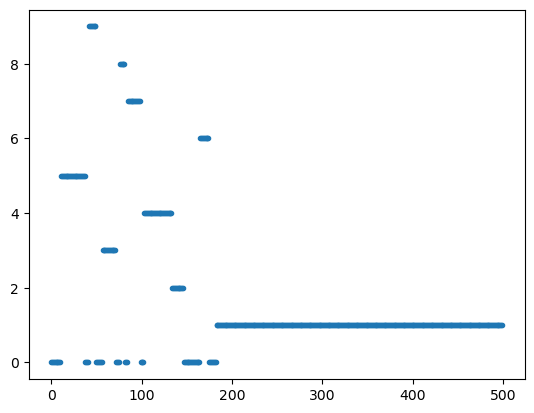

In [45]:
# Fitting K-Means to the dataset
from sklearn.cluster import KMeans
X=X1
kmeans = KMeans(n_clusters = 10, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)
plt.plot(y_kmeans, ".")
plt.show()

In [46]:
def print_cluster(i):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

In [47]:
# Optimal clusters is 
true_k = 10

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X1)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print_cluster(i)

Top terms per cluster:
Cluster 0:
 972683275
 594296420
 970407998
 594033896
 439886341
 059400232x
 879393742
 777700018
 743610431
 089933623x
Cluster 1:
 528881469
 972683275
 594012015
 594287995
 594202442
 594033934
 594033926
 594033896
 594017580
 594017343
Cluster 2:
 594481813
 972683275
 594450209
 594287995
 594202442
 594033934
 594033926
 594033896
 594017580
 594017343
Cluster 3:
 594481902
 972683275
 594450209
 594287995
 594202442
 594033934
 594033926
 594033896
 594017580
 594017343
Cluster 4:
 594033926
 972683275
 594012015
 594287995
 594202442
 594033934
 594033896
 594017580
 594017343
 558835155
Cluster 5:
 594012015
 972683275
 594287995
 594202442
 594033934
 594033926
 594033896
 594017580
 594017343
 558835155
Cluster 6:
 594451647
 972683275
 594450209
 594287995
 594202442
 594033934
 594033926
 594033896
 594017580
 594017343
Cluster 7:
 899336795
 972683275
 594012015
 594287995
 594202442
 594033934
 594033926
 594033896
 594017580
 594017343
Cluster

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [48]:
def show_recommendations(product):
    #print("Cluster ID:")
    Y = vectorizer.transform([product])
    prediction = model.predict(Y)
    #print(prediction)
    print_cluster(prediction[0])

In [49]:
class RecommenderGraph:
    def __init__(self):
        self.graph = {}

    def add_user(self, user_id):
        if user_id not in self.graph:
            self.graph[user_id] = {}

    def add_interaction(self, user_id, item_id, weight=1):
        self.add_user(user_id)
        if item_id not in self.graph[user_id]:
            self.graph[user_id][item_id] = weight
        else:
            self.graph[user_id][item_id] += weight

    def get_interactions(self, user_id):
        return self.graph.get(user_id, {})

    def recommend_items(self, user_id, n=5):
        user_interactions = self.get_interactions(user_id)
        recommendations = []
        for other_user_id, items in self.graph.items():
            if other_user_id != user_id:
                for item_id, weight in items.items():
                    if item_id not in user_interactions:
                        recommendations.append((item_id, weight))
        recommendations.sort(key=lambda x: x[1], reverse=True)
        return recommendations[:n]

# Example usage:
if __name__ == "__main__":
    recommender = RecommenderGraph()

    # Adding interactions
    recommender.add_interaction("user1", "item1")
    recommender.add_interaction("user1", "item2")
    recommender.add_interaction("user2", "item1")
    recommender.add_interaction("user2", "item3")
    recommender.add_interaction("user3", "item2")

    # Recommending items for a user
    user_id = "user1"
    recommendations = recommender.recommend_items(user_id)
    print(f"Recommendations for {user_id}: {recommendations}")


Recommendations for user1: [('item3', 1)]


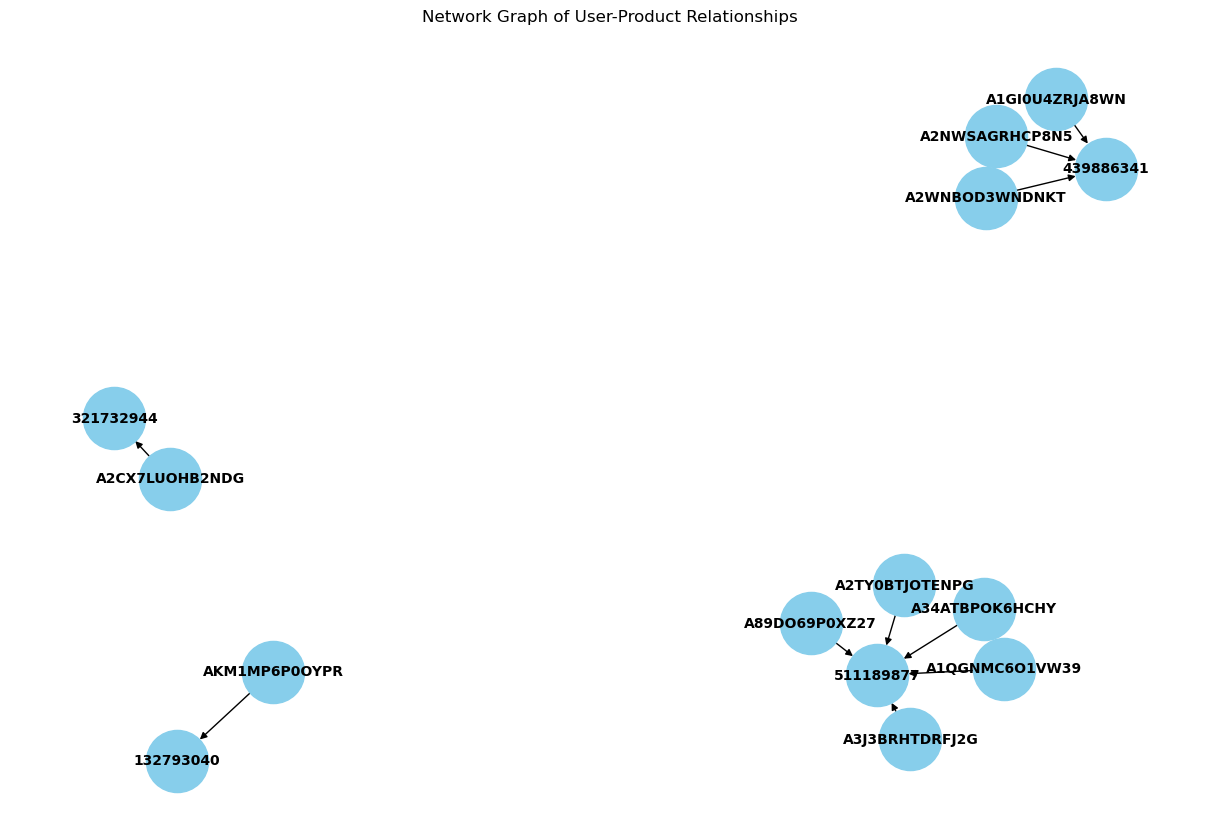

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Define your dataset
data = {
    'UserId': ['AKM1MP6P0OYPR', 'A2CX7LUOHB2NDG', 'A2NWSAGRHCP8N5', 'A2WNBOD3WNDNKT', 'A1GI0U4ZRJA8WN', 
               'A1QGNMC6O1VW39', 'A3J3BRHTDRFJ2G', 'A2TY0BTJOTENPG', 'A34ATBPOK6HCHY', 'A89DO69P0XZ27'],
    'ProductId': ['132793040', '321732944', '439886341', '439886341', '439886341', '511189877', '511189877', 
                  '511189877', '511189877', '511189877'],
    'Ratings': [5, 5, 1, 3, 1, 5, 2, 5, 5, 5],
    'Times': [1365811200, 1341100800, 1367193600, 1374451200, 1334707200, 1397433600, 1397433600, 1395878400, 
              1395532800, 1395446400]
}

# Create a pandas DataFrame
df = pd.DataFrame(data)

# Create a directed graph
G = nx.from_pandas_edgelist(df, source='UserId', target='ProductId', edge_attr=True, create_using=nx.DiGraph())

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold', pos=pos)
plt.title('Network Graph of User-Product Relationships')
plt.show()

In [68]:
X_train, y_train = generate_data(n_train = 300, train_only = True, n_features = 2) 

outlier_fraction = 0.1

X_outliers, X_inliers = get_outliers_inliers(X_train, y_train) 
n_inliers = len(X_inliers) 
n_outliers = len(X_outliers) 

f1 = X_train[:, [0]].reshape(-1, 1) 
f2 = X_train[:, [1]].reshape(-1, 1) 


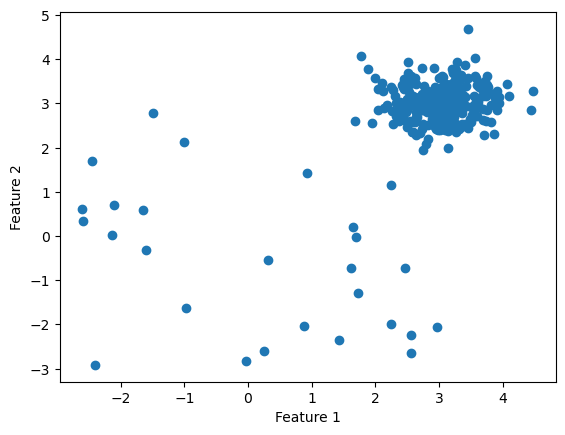

In [69]:
xx, yy = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(-10, 10, 200)) 

plt.scatter(f1, f2) 
plt.xlabel('Feature 1') 
plt.ylabel('Feature 2') 
plt.show()

In [70]:
clf = KNN(contamination = outlier_fraction) 
clf.fit(X_train, y_train) 

scores_pred = clf.decision_function(X_train)*-1

y_pred = clf.predict(X_train) 
n_errors = (y_pred != y_train).sum() 

print('The number of prediction errors are ' + str(n_errors)) 


The number of prediction errors are 4


C:\Users\Ionix.LAPTOP-9VQJ3UH1\AppData\Roaming\Python\Python39\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


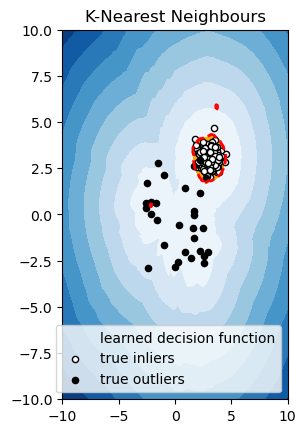

In [71]:
threshold = stats.scoreatpercentile(scores_pred, 100 * outlier_fraction) 
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape) 

subplot = plt.subplot(1, 2, 1) 
subplot.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 10), cmap = plt.cm.Blues_r) 

a = subplot.contour(xx, yy, Z, levels =[threshold], linewidths = 2, colors ='red') 

subplot.contourf(xx, yy, Z, levels =[threshold, Z.max()], colors ='orange') 

b = subplot.scatter(X_train[:-n_outliers, 0], X_train[:-n_outliers, 1], c ='white', s = 20, edgecolor ='k') 

c = subplot.scatter(X_train[-n_outliers:, 0], X_train[-n_outliers:, 1], c ='black', s = 20, edgecolor ='k') 
subplot.axis('tight') 

subplot.legend([a.collections[0], b, c], ['learned decision function', 'true inliers', 'true outliers'], 
               prop = matplotlib.font_manager.FontProperties(size = 10), loc ='lower right') 

subplot.set_title('K-Nearest Neighbours') 
subplot.set_xlim((-10, 10)) 
subplot.set_ylim((-10, 10)) 
plt.show() 

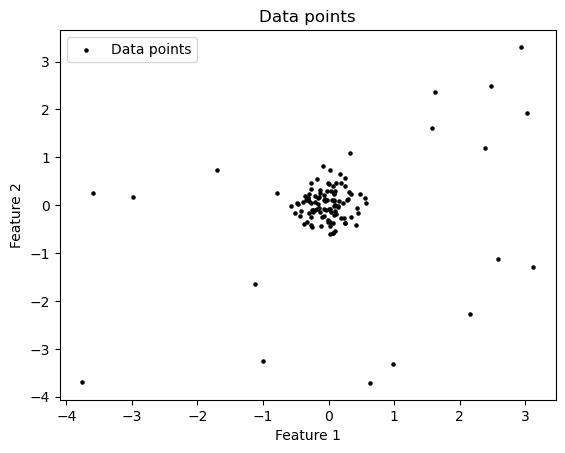

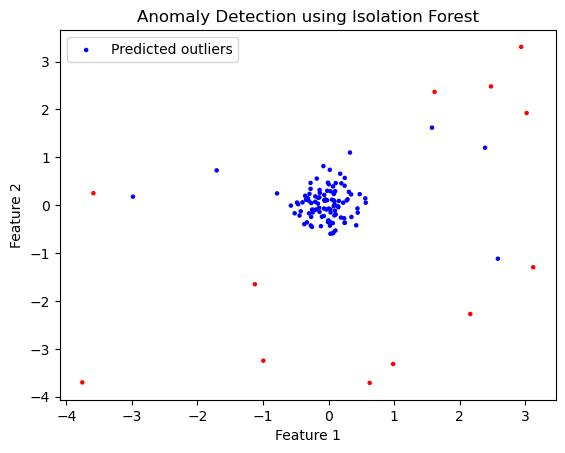

In [54]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Generating some sample data (2D)
np.random.seed(42)
X = 0.3 * np.random.randn(100, 2)
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.vstack([X, X_outliers])

# Plotting the data
plt.scatter(X[:, 0], X[:, 1], color='black', s=5, label='Data points')
plt.title("Data points")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

# Isolation Forest model training
clf = IsolationForest(contamination=0.1, random_state=42)
clf.fit(X)

# Predicting anomalies
y_pred = clf.predict(X)

# Plotting the results
plt.scatter(X[:, 0], X[:, 1], color=np.where(y_pred == 1, 'blue', 'red'), s=5, label='Predicted outliers')
plt.title("Anomaly Detection using Isolation Forest")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [55]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Generate some synthetic data
np.random.seed(42)
normal_data = np.random.normal(loc=0, scale=1, size=(1000, 2))
anomaly_data = np.random.normal(loc=5, scale=1, size=(100, 2))

# Combine normal and anomaly data
X = np.vstack([normal_data, anomaly_data])
y = np.hstack([np.zeros(len(normal_data)), np.ones(len(anomaly_data))])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Naive Bayes anomaly detection
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred))
print("Confusion Matrix (Naive Bayes):\n", confusion_matrix(y_test, nb_pred))

# K-Nearest Neighbors anomaly detection
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

print("\nK-Nearest Neighbors Accuracy:", accuracy_score(y_test, knn_pred))
print("Confusion Matrix (K-Nearest Neighbors):\n", confusion_matrix(y_test, knn_pred))


Naive Bayes Accuracy: 1.0
Confusion Matrix (Naive Bayes):
 [[307   0]
 [  0  23]]

K-Nearest Neighbors Accuracy: 1.0
Confusion Matrix (K-Nearest Neighbors):
 [[307   0]
 [  0  23]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


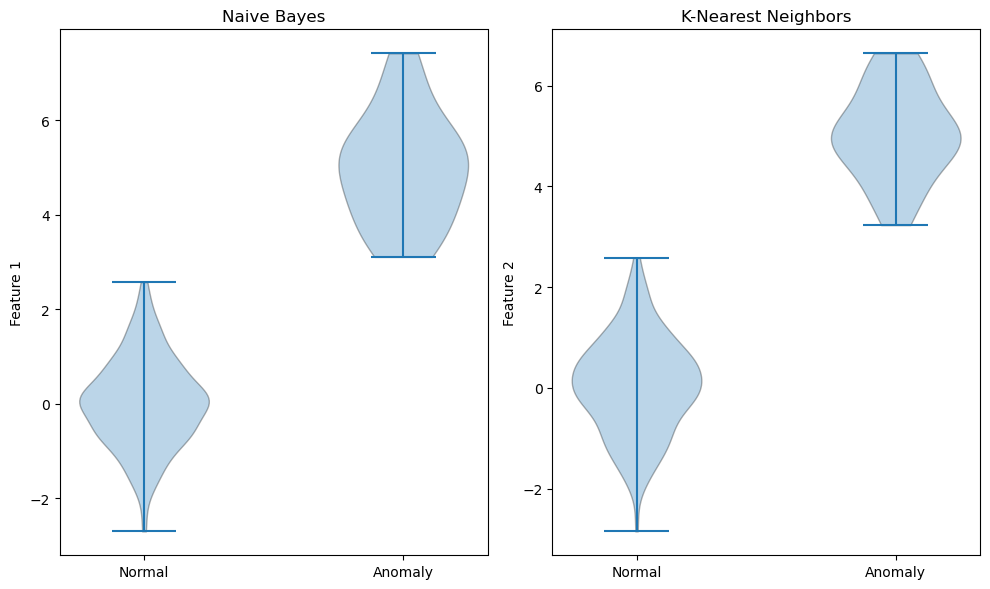

In [56]:
# Plotting violin plots
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title("Naive Bayes")
plt.violinplot([X_test[y_test == 0][:, 0], X_test[y_test == 1][:, 0]])
plt.xticks([1, 2], ['Normal', 'Anomaly'])
plt.ylabel('Feature 1')

plt.subplot(1, 2, 2)
plt.title("K-Nearest Neighbors")
plt.violinplot([X_test[y_test == 0][:, 1], X_test[y_test == 1][:, 1]])
plt.xticks([1, 2], ['Normal', 'Anomaly'])
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

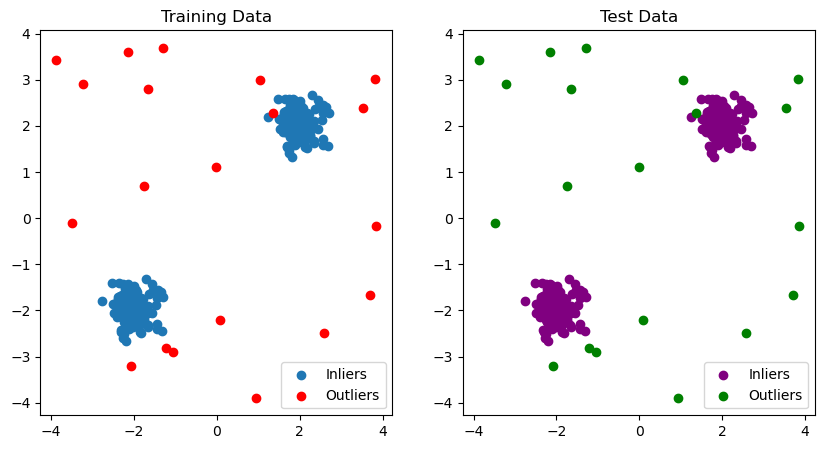

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

# Generating some example data
np.random.seed(0)
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
X_test = np.r_[X + 2, X - 2]

# Adding outliers
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# Training the model
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)

# Predictions
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# Plotting
plt.figure(figsize=(10, 5))

# Training data
plt.subplot(1, 2, 1)
plt.title("Training Data")
plt.scatter(X_train[:, 0], X_train[:, 1], label='Inliers')
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], label='Outliers', color='red')
plt.legend()

# Testing data
plt.subplot(1, 2, 2)
plt.title("Test Data")
plt.scatter(X_test[:, 0], X_test[:, 1], label='Inliers' , color='purple')
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], label='Outliers', color='green')
plt.legend()

plt.show()


In [58]:
# Sample data (replace this with your actual data)
data = {
    'UserID': ["AKM1MP6P0OYPR","A2CX7LUOHB2NDG","A2NWSAGRHCP8N5", "A2WNBOD3WNDNKT",
"A1GI0U4ZRJA8WN",
"A1QGNMC6O1VW39",
"A3J3BRHTDRFJ2G",
"A2TY0BTJOTENPG",
"A34ATBPOK6HCHY",
"A89DO69P0XZ27",
"AZYNQZ94U6VDB",
"A1DA3W4GTFXP6O",
"A29LPQQDG7LD5J",
"AO94DHGC771SJ",
"AMO214LNFCEI4",
"A28B1G1MSJ6OO1",
"A3N7T0DY83Y4IG",
"A1H8PY3QHMQQA0",
"A2CPBQ5W4OGBX",
"A265MKAR2WEH3Y",
"A37K02NKUIT68K",
"A2AW1SSVUIYV9Y",
"A2AEHUKOV014BP",
"AMLFNXUIEMN4T",
"A2O8FIJR9EBU56",
"A3IQGFB959IR4P",
"AYTBGUX49LF3W",
"A24QFSUU00IZ05",
"A1NG5X8VYZWX0Q",
"A1E4WG8HRWWK4R",
"A2AOEW5UGXFOOQ",
"A2XSWV6AQI90BR",
"AR84FMFYCQCWF",
"A19TBA1WARJS55",
"A3C5SMBSKKWNPT",
"A24EV6RXELQZ63",
"A3T6ZQONABIJSG",
"A132P6YSJSI5G2",
"A1NQPG5IJ43HJI",
],
    'ProductID': [132793040,
321732944,
439886341,
439886341,
439886341,
511189877,
511189877,
511189877,
511189877,
511189877,
511189877,
528881469,
528881469,
528881469,
528881469,
528881469,
528881469,
528881469,
528881469,
528881469,
528881469,
528881469,
528881469,
528881469,
528881469,
528881469,
528881469,
528881469,
528881469,
528881469,
528881469,
528881469,
528881469,
528881469,
528881469,
528881469,
528881469,
528881469,
558835155,
],
    'Ratings': [5,
5,
1,
3,
1,
5,
2,
5,
5,
5,
5,
5,
1,
5,
1,
4,
3,
2,
2,
4,
5,
4,
5,
1,
4,
1,
4,
2,
1,
5,
5,
1,
1,
2,
5,
1,
1,
2,
3,
]
}

# Create DataFrame
df = pd.DataFrame(data)

# Encode categorical variables
encoder = LabelEncoder()
df['UserID'] = encoder.fit_transform(df['UserID'])
df['ProductID'] = encoder.fit_transform(df['ProductID'])

# Split data into features and target
X = df[['UserID', 'ProductID']]
y = df['Ratings']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define SVM classifier
svm_classifier = SVC(kernel='linear')

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['UserID', 'ProductID'])
    ])

# Create pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', svm_classifier)])

# Fit the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.25

Classification Report:
               precision    recall  f1-score   support

           1       0.33      0.50      0.40         2
           2       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1
           5       0.20      0.50      0.29         2

    accuracy                           0.25         8
   macro avg       0.13      0.25      0.17         8
weighted avg       0.13      0.25      0.17         8



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


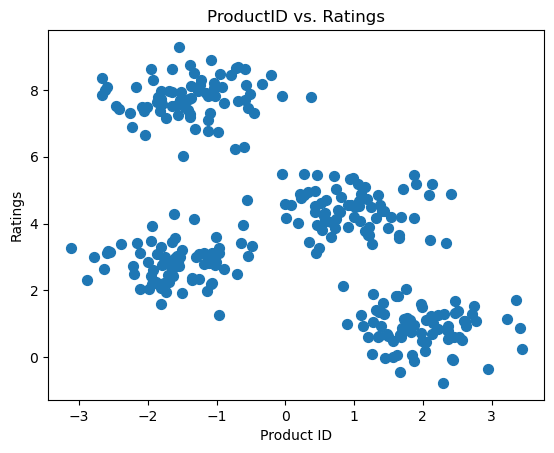

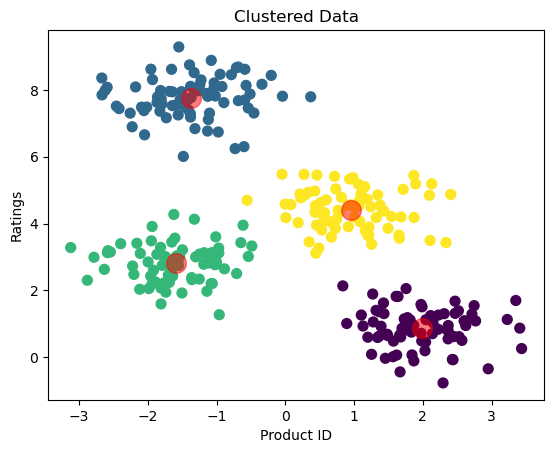

In [60]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Generating sample data
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# Visualizing the sample data
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.xlabel('Product ID')
plt.ylabel('Ratings')
plt.title('ProductID vs. Ratings')
plt.show()

# Performing KMeans clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

# Getting cluster centers and labels
centers = kmeans.cluster_centers_
labels = kmeans.labels_

# Visualizing the clustered data
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
plt.xlabel('Product ID')
plt.ylabel('Ratings')
plt.title('Clustered Data')
plt.show()